### The adult census dataset

Original author's [dataset exploration](https://github.com/INRIA/scikit-learn-mooc/blob/main/notebooks/datasets_adult_census.ipynb) and [random forest example](https://github.com/INRIA/scikit-learn-mooc/blob/main/notebooks/ensemble_random_forest.ipynb)
Under a CC-BY License by Inria Learning Lab, scikit-learn @ La Fondation Inria, Inria Academy.

[This dataset](https://www.openml.org/search?type=data&sort=runs&id=1590&status=active) is a collection of demographic information for the adult population as of 1994 in the USA. The prediction task is to predict whether a person is earning a high or low revenue in USD/year.

The column named **class** is the target variable (i.e., the variable which we want to predict). The two possible classes are " <=50K" (low-revenue) and " >50K" (high-revenue).

Before drawing any conclusions based on its statistics or the predictions of models trained on it, remember that this dataset is not only outdated, but is also not representative of the US population. In fact, the original data contains a feature named fnlwgt that encodes the number of units in the target population that the responding unit represents.

First we load the dataset. We keep only some columns of interest to ease the plotting.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving adult-census.csv to adult-census.csv


In [3]:
import pandas as pd

adult_census = pd.read_csv("adult-census.csv")
columns_to_plot = [
    "age",
    "education-num",
    "capital-loss",
    "capital-gain",
    "hours-per-week",
    "relationship",
    "class",
]
target_name = "class"
target = adult_census[target_name]

Here we explore with some more detail the relation between features using plotly Parcoords.

In [4]:
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()


def generate_dict(col):
    """Check if column is categorical and generate the appropriate dict"""
    if adult_census[col].dtype == "object":  # Categorical column
        encoded = le.fit_transform(adult_census[col])
        return {
            "tickvals": list(range(len(le.classes_))),
            "ticktext": list(le.classes_),
            "label": col,
            "values": encoded,
        }
    else:  # Numerical column
        return {"label": col, "values": adult_census[col]}


plot_list = [generate_dict(col) for col in columns_to_plot]

fig = go.Figure(
    data=go.Parcoords(
        line=dict(
            color=le.fit_transform(target),
            colorscale="Viridis",
        ),
        dimensions=plot_list,
    )
)
fig.show()

It display the values of the features on different columns while the target class is color coded. Thus, we are able to quickly inspect if there is a range of values for a certain feature which is leading to a particular result.

It is possible to select one or more ranges of values by clicking and holding on any axis of the plot. You can then slide (move) the range selection and cross two selections to see the intersections. You can undo a selection by clicking once again on the same axis.

In particular for this dataset we observe that values of "age" lower to 20 years are quite predictive of low-income, regardless of the value of other features. Similarly, a "capital-loss" above 4000 seems to lead to low-income.

One can additionally explore correlations between features, for example, using Spearman's rank correlation, as the more popular Pearson's correlation is only appropriate for continuous data that is normally distributed and linearly related. Spearman's correlation is more versatile in dealing with non-linear relationships and ordinal data, but it is not meant for nominal categorical data.

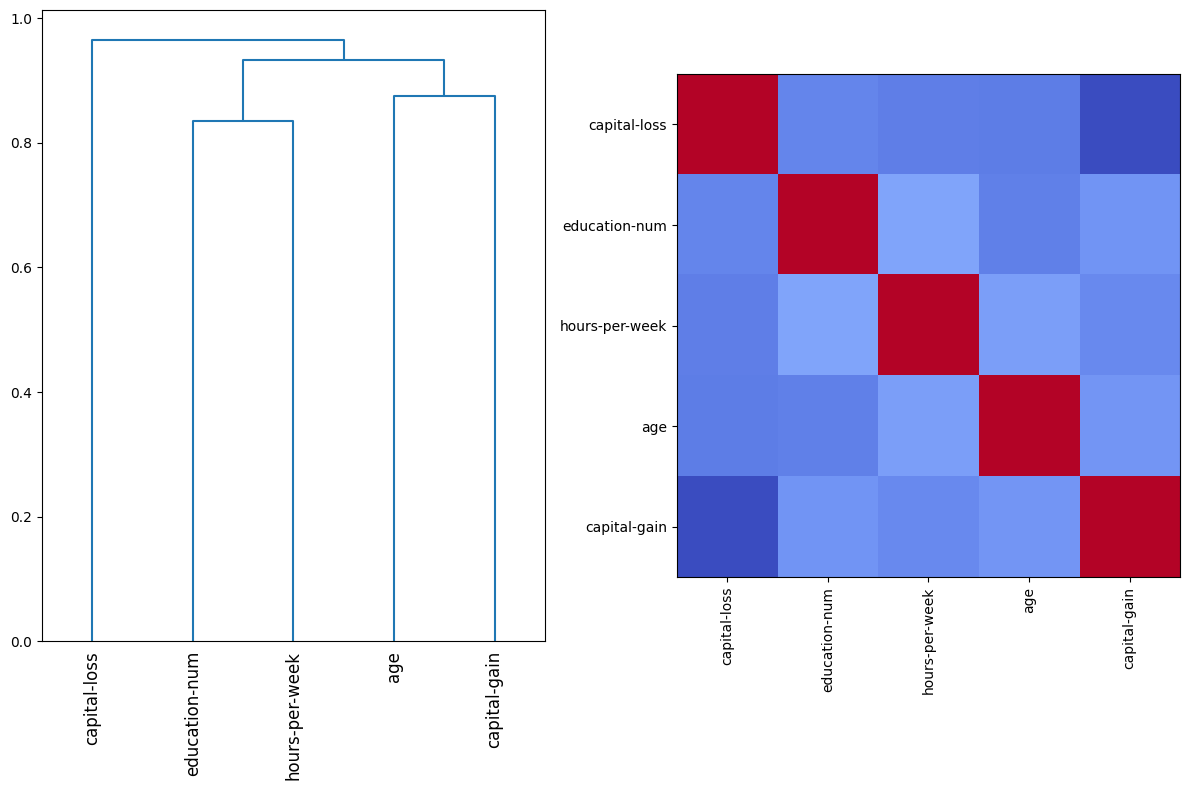

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

# Keep numerical features only
X = adult_census[columns_to_plot].drop(columns=["class", "relationship"])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap="coolwarm")
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

Using a [diverging colormap](https://matplotlib.org/stable/users/explain/colors/colormaps.html#diverging) such as "coolwarm", the softer the color, the less (anti)correlation between features (no correlation is mapped to white color). In this case dark blue represents strong negative correlations and dark red means strong positive correlations. Indeed, any feature is perfectly correlated to itself.

### Random Forests

Random forests are a popular model in machine learning. They are a modification of the bagging algorithm. In bagging, any classifier or regressor can be used. In random forests, the base classifier or regressor is always a decision tree.

Random forests have another particularity: when training a tree, the search for the best split is done only on a subset of the original features taken at random. The random subsets are different for each split node. The goal is to inject additional randomization into the learning procedure to try to decorrelate the prediction errors of the individual trees.  
  
Therefore, random forests are using **randomization on both axes of the data matrix**:  
  
- by **bootstrapping samples** for **each tree** in the forest;  
- randomly selecting a **subset of features** at **each node** of the tree.

#### A look at random forests

In [6]:
import pandas as pd

target_name = "class"
data = adult_census.drop(columns=[target_name, "education-num"])
target = adult_census[target_name]

The adult census contains some categorical data and we encode the categorical features using an OrdinalEncoder since tree-based models can work very efficiently with such a naive representation of categorical variables.

Since there are rare categories in this dataset we need to specifically encode unknown categories at prediction time in order to be able to use cross-validation. Otherwise some rare categories could only be present on the validation side of the cross-validation split and the OrdinalEncoder would raise an error when calling its transform method with the data points of the validation set.

OrdinalEncoder is a transformer in scikit-learn that encodes categorical features as ordinal integers (0, 1, 2, ...) based on the order of unique values in each column.

handle_unknown="use_encoded_value" specifies that unknown categories should be assigned the value specified by the unknown_value parameter.  
  
unknown_value=-1 sets the value to be assigned to unknown categories to -1.

make_column_transformer is a utility function for creating a column transformer, which applies different transformers to different subsets of the columns.  

(categorical_encoder, make_column_selector(dtype_include=object)): This specifies that the categorical_encoder should be applied to columns with a data type of object. It identifies categorical columns based on their data type.  
  
  
    
remainder="passthrough": This parameter indicates that any columns not specified in the previous transformers should be left unchanged (i.e., passed through without transformation).


In [7]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = make_column_transformer(
    (categorical_encoder, make_column_selector(dtype_include=object)),
    remainder="passthrough",
)

We will first give a simple example where we will train a single decision tree classifier and check its generalization performance via cross-validation.

[Cross-validation explained](https://www.youtube.com/watch?v=fSytzGwwBVw)  
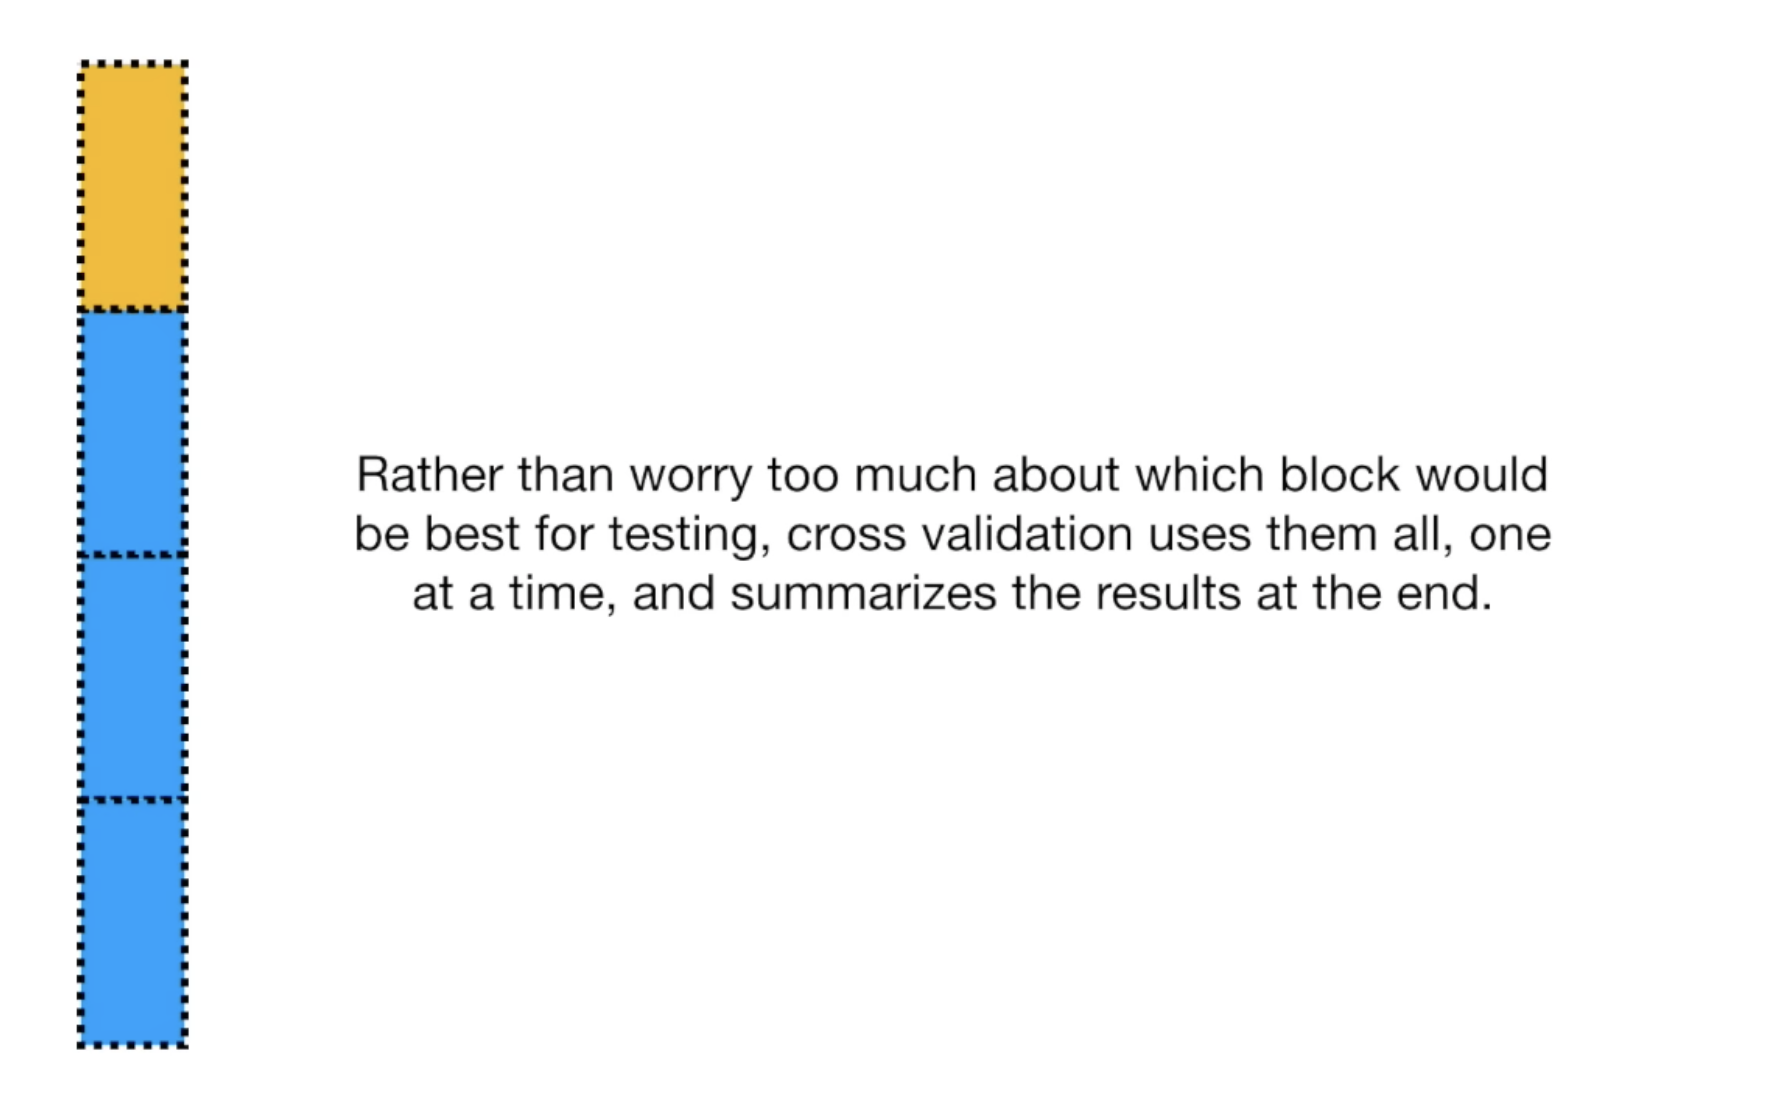

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

tree = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=0))

In [9]:
from sklearn.model_selection import cross_val_score

scores_tree = cross_val_score(tree, data, target)

print(
    "Decision tree classifier: "
    f"{scores_tree.mean():.3f} ± {scores_tree.std():.3f}"
)

Decision tree classifier: 0.820 ± 0.006


Ensemble Method:  
- Bagging with Decision Trees: Uses bagging (Bootstrap Aggregating) to train multiple instances of the base estimator on bootstrapped samples of the dataset and aggregates their predictions.  
  
- Random Forest: Builds an ensemble of decision trees using a technique known as bagging but adds randomness by considering only a subset of features at each split in each tree.

 We construct a BaggingClassifier with a decision tree classifier as base model. In addition, we need to specify how many models do we want to combine. Note that we also need to preprocess the data and thus use a scikit-learn pipeline.

In [10]:
from sklearn.ensemble import BaggingClassifier

bagged_trees = make_pipeline(
    preprocessor,
    BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=0),
        n_estimators=50,
        n_jobs=2,
        random_state=0,
    ),
)

In [11]:
scores_bagged_trees = cross_val_score(bagged_trees, data, target)

print(
    "Bagged decision tree classifier: "
    f"{scores_bagged_trees.mean():.3f} ± {scores_bagged_trees.std():.3f}"
)

Bagged decision tree classifier: 0.846 ± 0.005


Note that the generalization performance of the bagged trees is already much better than the performance of a single tree.

Now, we will use a random forest. You will observe that we do not need to specify any estimator because the estimator is forced to be a decision tree. Thus, we just specify the desired number of trees in the forest.

In [12]:
from sklearn.ensemble import RandomForestClassifier

random_forest = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=0),
)

In [13]:
scores_random_forest = cross_val_score(random_forest, data, target)

print(
    "Random forest classifier: "
    f"{scores_random_forest.mean():.3f} ± "
    f"{scores_random_forest.std():.3f}"
)

Random forest classifier: 0.851 ± 0.004


It seems that the random forest is performing slightly better than the bagged trees possibly due to the randomized selection of the features which decorrelates the prediction errors of individual trees and as a consequence make the averaging step more efficient at reducing overfitting.

Details about default hyperparameters  
  
For random forests, it is possible to control the amount of randomness for each split by setting the value of max_features hyperparameter:  
  
- max_features =0 .5 means that 50% of the features are considered at each split;  
- max_features = 1.0 means that all features are considered at each split which effectively disables feature subsampling.  
  
By default, RandomForestClassifier uses max_features=np.sqrt(n_features). These default values reflect good practices given in the scientific literature.  
  
However, max_features is one of the hyperparameters to consider when tuning a random forest:  
  
- too much randomness in the trees can lead to underfitted base models and can be detrimental for the ensemble as a whole,  
- too few randomness in the trees leads to more correlation of the prediction errors and as a result reduce the benefits of the averaging step in terms of overfitting control.  